Sample image size: 32x32, input_dim: 1024
1


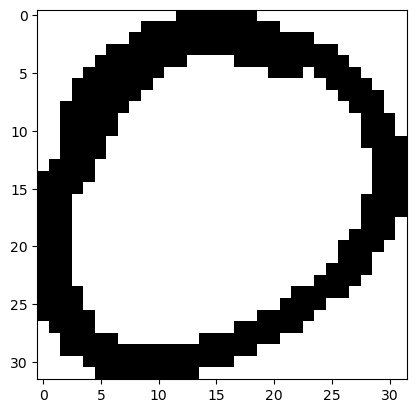

NameError: name 'input_shape' is not defined

In [17]:
#!/usr/bin/env python
# coding: utf-8
# In[925]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from PIL import Image
import matplotlib.pyplot as plt
# In[926]:
# Taking sample image to measure dimensions
sample_image_path = '/Users/sundarasubramanian/yoyo/CIS-583/HW3/Q2_GurMukhi/GurNum/train/0/1.bmp'
sample_image = Image.open(sample_image_path)
width, height = sample_image.size
input_dim = width * height
print(f"Sample image size: {width}x{height}, input_dim: {input_dim}")
print(sample_image.mode)
#Show sample image
plt.imshow(sample_image)
plt.show()
# In[928]:
class GurmukhiNN(nn.Module):
    def __init__(self, input_dim, output_dim, dropout_prob):
        super(GurmukhiNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        conv_output_size = (height // 4) * (width // 4) * 64
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1) # Input: [B, 1, H, W]
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        # Compute correct input size for FC layer
        conv_output_size = 4096 # After 2 pooling layers
        self.fc1 = nn.Linear(conv_output_size, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 64)
        self.fco = nn.Linear(64, output_dim)
        self.dropout_prob = dropout_prob
    def forward(self, x):
        # x = x.view(x.size(0), -1)
        # x = x.unsqueeze(1)
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        # Manual dropout calculation
        if self.training:
            mask = (torch.rand(x.shape, device=x.device) >
            self.dropout_prob).float()
            x = x * mask / (1.0 - self.dropout_prob)
        x = self.fco(x)
        return x
# In[927]:
# Preprocessing the dataset
transform = transforms.Compose([
transforms.Grayscale(num_output_channels=1),
transforms.ToTensor(),
transforms.Normalize((0.5,), (0.5,))
])
# Replace with actual dataset folder
train_dataset = datasets.ImageFolder(root='/Users/sundarasubramanian/yoyo/CIS-583/HW3/Q2_GurMukhi/GurNum/train', transform=transform)
test_dataset = datasets.ImageFolder(root='/Users/sundarasubramanian/yoyo/CIS-583/HW3/Q2_GurMukhi/GurNum/val', transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
output_dim = 10 # For digits 0-9
num_epochs= 10
dropout_prob = 0.4
# input_shape = (1, height, width) # Since it's grayscale (1 channel)
model = GurmukhiNN(input_shape, output_dim=10, dropout_prob=0.4)
# model = GurmukhiNN(input_dim, output_dim, dropout_prob)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
dataiter = iter(train_loader)
images, labels = images.to(device), labels.to(device)
images, labels = next(dataiter)
# In[929]:
def compute_loss(model, output, target, lambda_l1=0.0, lambda_l2=0.0):
    # Manual loss calculation and L1, L2 regularization
    criterion = nn.CrossEntropyLoss()
    loss = criterion(output, target)
    l1_reg = sum(p.abs().sum() for p in model.parameters())
    l2_reg = sum((p ** 2).sum() for p in model.parameters())
    loss = loss + lambda_l1 * l1_reg + lambda_l2 * l2_reg
    return loss
# In[930]:
# L1, L2, regularization methods
def l1_regularization(model, lambda_l1=0.001):
    l1_norm = sum(p.abs().sum() for p in model.parameters())
    return lambda_l1 * l1_norm
def l2_regularization(model, lambda_l2=0.001):
    l2_norm = sum((p ** 2).sum() for p in model.parameters())
    return lambda_l2 * l2_norm
# In[931]:
# Evaluate and plot accuracy
def evaluate_accuracy(model, loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in loader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
    return 100 * correct / total
# In[932]:
# train and test with manual gradient checking and plotting
# train and test with manual gradient checking and plotting
def train_model_with_manual_grad_check(model, train_loader, test_loader, optimizer, 
                                       l1_lambda=0.0, l2_lambda=0.0, epsilon=1e-5):
    train_acc_list = []
    test_acc_list = []
    grad_norm_list = []
    
    for epoch in range(num_epochs):
        model.eval()
        running_loss = 0.0
        batch_grad_norms = []
        
        for inputs, targets in train_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = compute_loss(model, outputs, targets, l1_lambda, l2_lambda)
            loss.backward()

            # Manual Gradient Checking
            manual_grad_norm =0.0
            for param in model.parameters():
                if param.requires_grad:
                    param_data = param.data.clone()
                    grad = torch.zeros_like(param)

                    for i in range(param.numel()):
                        param_data_flat = param_data.view(-1)

                        # Compute f(x + epsilon)
                        param_data_flat[i] += epsilon
                        model.zero_grad()
                        outputs_plus = model(inputs)
                        loss_plus = compute_loss(model, outputs_plus, targets, l1_lambda, l2_lambda)

                        # Compute f(x - epsilon)
                        param_data_flat[i] -= 2 * epsilon
                        model.zero_grad()
                        outputs_minus = model(inputs)
                        loss_minus = compute_loss(model, outputs_minus, targets, l1_lambda, l2_lambda)

                        # Compute gradient
                        grad.view(-1)[i] = (loss_plus - loss_minus) / (2 * epsilon)

                        # Restore original value
                        param_data_flat[i] += epsilon

                    manual_grad_norm += torch.norm(grad).item() ** 2
            manual_grad_norm = manual_grad_norm ** 0.5
            batch_grad_norms.append(manual_grad_norm)


            optimizer.step()
            running_loss += loss.item()
        
        avg_grad_norm = sum(batch_grad_norms) / len(batch_grad_norms)
        grad_norm_list.append(avg_grad_norm)
        train_acc = evaluate_accuracy(model, train_loader)
        test_acc = evaluate_accuracy(model, test_loader)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        
        print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {running_loss/len(train_loader):.4f}, "
              f"Train Acc: {train_acc:.2f}%, Test Acc: {test_acc:.2f}%, Grad Norm: {avg_grad_norm:.4f}")
    
    return train_acc_list, test_acc_list, grad_norm_list
# In[933]:
print("Training with L2 regularization (λ2=0.001)")
train_acc, test_acc, grad_norms = train_model_with_plots(
model, train_loader, test_loader, optimizer, l1_lambda=0.0, l2_lambda=0.001
)
epochs = range(1, num_epochs+1)
plt.figure(figsize=(12, 5))
# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs, train_acc, label='Train Accuracy')
plt.plot(epochs, test_acc, label='Test Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Training and Test Accuracy")
plt.legend()
# Plot Gradient Norms
plt.subplot(1, 2, 2)
plt.plot(epochs, grad_norms, 'r-', label='Avg Gradient Norm')
plt.xlabel("Epoch")
plt.ylabel("Gradient Norm")
plt.title("Average Gradient Norm per Epoch")
plt.legend()
plt.tight_layout()
plt.show()
# In[934]:
print("Training with L1 regularization (λ1=0.001)")
train_acc, test_acc, grad_norms = train_model_with_plots(
model, train_loader, test_loader, optimizer, l1_lambda=0.001, l2_lambda=0.0
)
epochs = range(1, num_epochs+1)
plt.figure(figsize=(12, 5))
# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs, train_acc, label='Train Accuracy')
plt.plot(epochs, test_acc, label='Test Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Training and Test Accuracy")
plt.legend()
# Plot Gradient Norms
plt.subplot(1, 2, 2)
plt.plot(epochs, grad_norms, 'r-', label='Avg Gradient Norm')
plt.xlabel("Epoch")
plt.ylabel("Gradient Norm")
plt.title("Average Gradient Norm per Epoch")
plt.legend()
plt.tight_layout()
plt.show()
# In[935]:
print("Training with Dropout regularization")
train_acc, test_acc, grad_norms = train_model_with_plots(
model, train_loader, test_loader, optimizer, l1_lambda=0.0, l2_lambda=0.0
)
epochs = range(1, num_epochs+1)
plt.figure(figsize=(12, 5))
# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs, train_acc, label='Train Accuracy')
plt.plot(epochs, test_acc, label='Test Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Training and Test Accuracy")
plt.legend()
# Plot Gradient Norms
plt.subplot(1, 2, 2)
plt.plot(epochs, grad_norms, 'r-', label='Avg Gradient Norm')
plt.xlabel("Epoch")
plt.ylabel("Gradient Norm")
plt.title("Average Gradient Norm per Epoch")
plt.legend()
plt.tight_layout()
plt.show()
# In[936]:
print("Training with L1, L2, Dropout regularization (λ1=0.001, λ2=0.001)")
train_acc, test_acc, grad_norms = train_model_with_plots(
model, train_loader, test_loader, optimizer, l1_lambda=0.001, l2_lambda=0.001
)
epochs = range(1, num_epochs+1)
plt.figure(figsize=(12, 5))
# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs, train_acc, label='Train Accuracy')
plt.plot(epochs, test_acc, label='Test Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Training and Test Accuracy")
plt.legend()
# Plot Gradient Norms
plt.subplot(1, 2, 2)
plt.plot(epochs, grad_norms, 'r-', label='Avg Gradient Norm')
plt.xlabel("Epoch")
plt.ylabel("Gradient Norm")
plt.title("Average Gradient Norm per Epoch")
plt.legend()
plt.tight_layout()
plt.show()
